In [1]:
import scanpy as sc
import anndata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import HSNE.tools as hsne_tl
import HSNE.plotting as hsne_pl

import HUMAP.tools as humap_tl
import HUMAP.plotting as humap_pl

In [2]:
# Load Dataset
print("Loading dataset")
filelocation = r"HSNE/test/datasets/VBh_converted.h5ad"
#filelocation = "C:/Users/xilef/Desktop/Helmholtz/CantoUnstained_converted.h5ad"
adata = anndata.read_h5ad(filelocation)
print(f"dataset with {len(adata)} cells loaded")

# subsampling (for slow/low memory computers)
#print("subsampling")
#sc.pp.subsample(adata, 0.4)

# removing some channels
for channel in adata.var_names:
    if channel.endswith("-H") or channel == "Time" or channel == "FSC-Width":
        adata.obs[channel]=adata.X[:,adata.var_names == channel]
        adata = adata[:,adata.var_names != channel]

# normalizing
print("Normalizing")
adata.X = np.arcsinh(adata.X / 10)

# calc knn
print("Calculating connectivities")
sc.pp.neighbors(adata, n_neighbors=20)

# calculating louvain clustering of original dataset
print("Calculating louvain clustering")
sc.tl.louvain(adata, resolution=0.5, key_added="louv_05")

print("Done!")

Loading dataset


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


dataset with 129467 cells loaded


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Normalizing
Calculating connectivities
Calculating louvain clustering
Done!


**HUMAP subsampling vs random subsampling**

A dataset will be reduced to 5% of its original size using the random subsampling method from scanpy and the HUMAP subsampling method.

In [3]:
adata_rand_sub = adata.copy()
adata_humap_sub = adata.copy()

# random subsampling
print("subsampling randomly")
sc.pp.subsample(adata_rand_sub, 0.05)
print("done")

# humap subsampling
print("subsampling with humap")
humap_tl.humap(adata_humap_sub, subs_mode="factor", factor=0.05)
adata_humap_sub = adata_humap_sub.uns["HUMAP_scales"][0]
print("done")

subsampling randomly
done
subsampling with humap
done


Original data


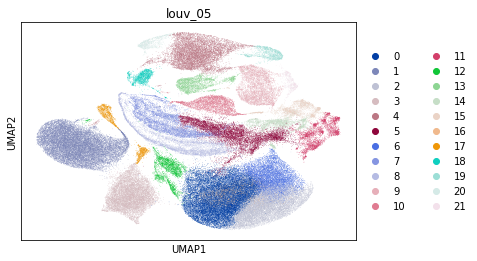

cellcount: 129467


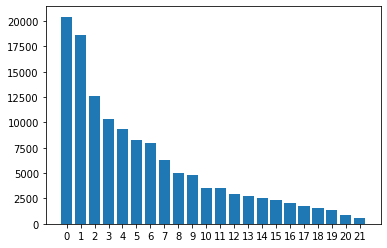

Randomly subsampled data


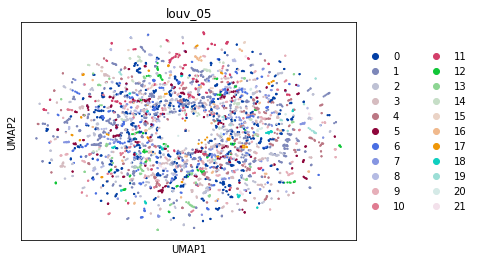

cellcount: 6473


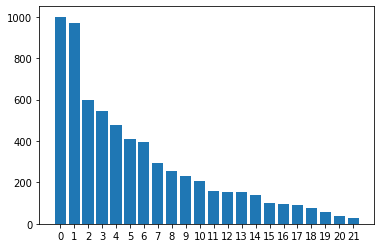

Humap subsampled Data


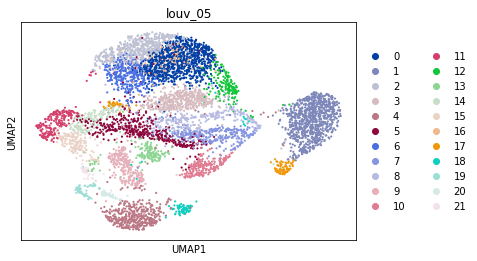

cellcount: 6473


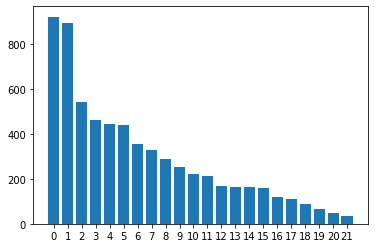

In [4]:
def printData(anndata_obj):
    # getting clustercounts
    if 'umap' not in anndata_obj.obsm:
        sc.tl.umap(anndata_obj)
    sc.pl.umap(anndata_obj, color="louv_05")
    clustercount = anndata_obj.obs["louv_05"].value_counts()
    plt.bar(np.arange(clustercount.count()), clustercount)
    plt.xticks(np.arange(clustercount.count()))
    
    cellcount = anndata_obj.X.shape[0]
    
    print(f"cellcount: {cellcount}")
    plt.show()


print("Original data")
printData(adata)

print("Randomly subsampled data")
printData(adata_rand_sub)

print("Humap subsampled Data")
printData(adata_humap_sub)
    
    


***The original dataset:***

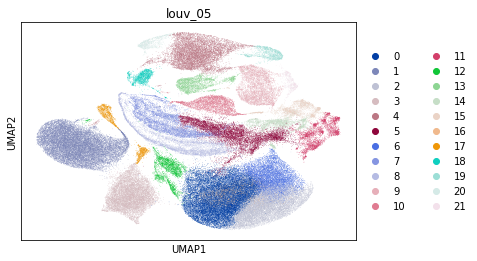

cellcount: 129467


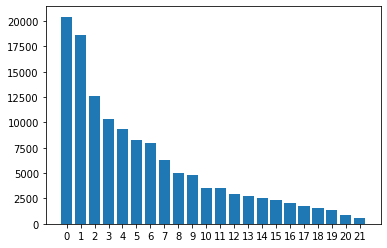

In [5]:
printData(adata)

***Subsampled with the random subsampling method***

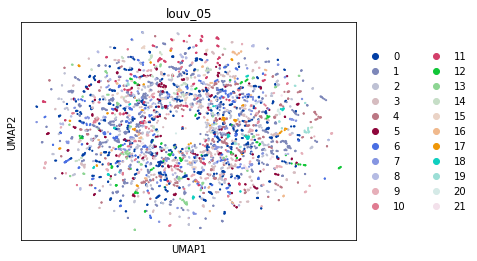

cellcount: 6473


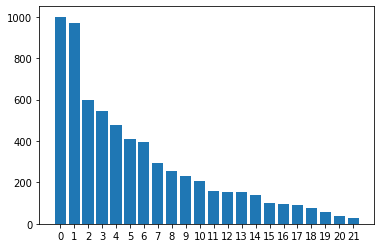

In [6]:
printData(adata_rand_sub)

***Subsampled with the HUMAP subsampling method***

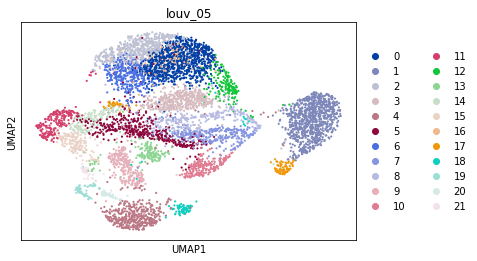

cellcount: 6473


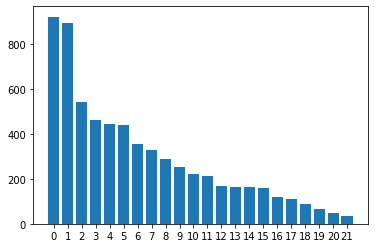

In [7]:
printData(adata_humap_sub)

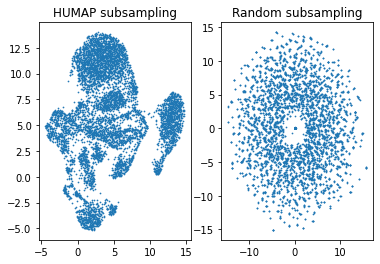

In [9]:
plt.subplot(1, 2, 1)
plt.title('HUMAP subsampling')
plt.scatter(x=adata_humap_sub.obsm['X_umap'][:,0], y=adata_humap_sub.obsm['X_umap'][:,1], s=0.5)
plt.subplot(1, 2, 2)
plt.title('Random subsampling')
plt.scatter(x=adata_rand_sub.obsm['X_umap'][:,0], y=adata_rand_sub.obsm['X_umap'][:,1], s=0.5)
plt.show()

**HSNE alt vs HSNE neu**

In [11]:
hsne_tl.hsne(adata_humap_sub, verbose=True)
hsne_pl.hsne(adata_humap_sub)

Starting hsne: 6473 points and 1 scales
T
P
lm_ind


KeyError: 'teta'